---

# **Imports**

In [23]:
import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import random
import ot

# **General functions**

In [24]:
def c(x, y, a):
    return y - a * np.maximum(x, y)

def uniform_support(a, b, n):
    return np.linspace(a, b, n)

def cost_matrix(xi, yj, a=0.5):
    return yj - a * np.maximum(xi[:, None], yj)

def project_onto_C1(p, mu):
    """Project p onto C1: Marginal matching for mu."""
    return p * (mu / (p.sum(axis=1) + 1e-8))

def project_onto_C2(p, nu):
    """Project p onto C2: Marginal matching for nu."""
    return p * (nu / (p.sum(axis=0) + 1e-8))

def project_onto_martingale_constraint(p, xi, yj, mu):
    """Project p onto C2+l: Martingale constraint."""
    expected_y_per_x = np.dot(p, yj) / (mu + 1e-8)
    adjustment_factors = xi / expected_y_per_x
    adjustment_factors = np.where(np.isnan(adjustment_factors), 1, adjustment_factors)
    p_adjusted = p * adjustment_factors[:, None]
    return p_adjusted

def bregman_projection(mu, nu, xi, yj, C, max_iter=100):
    m, n = C.shape
    p = np.exp(-C)  # Initial guess
    p /= np.sum(p)  # Normalize
    for _ in range(max_iter):
        p = project_onto_C1(p, mu)
        p = project_onto_C2(p, nu)
        p = project_onto_martingale_constraint(p, xi, yj, mu)
        # Normalize p again to ensure it's a probability distribution
        p /= np.sum(p)
       
    return p

---

# **Implementation of the Bregman Projection**

In [25]:
# Define the parameters for the uniform distributions
mu_a, mu_b = -1, 1
nu_a, nu_b = -2, 2
n = 100  # Number of support points for each distribution

# Generate the support points for mu and nu
xi = uniform_support(mu_a, mu_b, n)
yj = uniform_support(nu_a, nu_b, n)

# Generate the cost matrix
C = cost_matrix(xi, yj)

# Generate the uniform distributions mu and nu
mu = np.ones(n) / n
nu = np.ones(n) / n

# Perform the Bregman projection
p_star = bregman_projection(mu, nu, xi, yj, C)

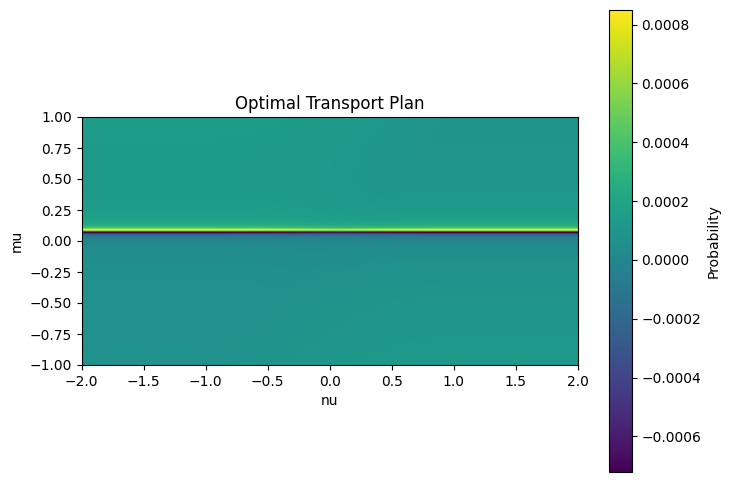

In [26]:
# Plot the optimal transport plan
plt.figure(figsize=(8, 6))
plt.imshow(p_star, cmap='viridis', origin='lower', extent=[nu_a, nu_b, mu_a, mu_b])
plt.colorbar(label='Probability')
plt.xlabel('nu')
plt.ylabel('mu')
plt.title('Optimal Transport Plan')
plt.show()

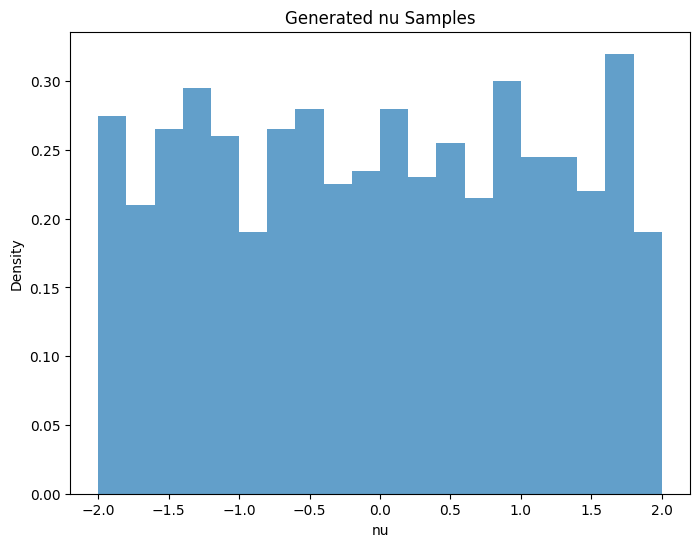

In [27]:
# Generate new nu samples using the optimal transport plan
num_samples = 1000
mu_samples = np.random.choice(xi, size=num_samples, p=mu)
nu_samples = []
for x in mu_samples:
    idx = np.where(xi == x)[0][0]
    p_row = p_star[idx] / np.sum(p_star[idx])  # Normalize the row probabilities
    nu_samples.append(np.random.choice(yj, p=p_row))
nu_samples = np.array(nu_samples)

# Plot the generated nu samples
plt.figure(figsize=(8, 6))
plt.hist(nu_samples, bins=20, density=True, alpha=0.7)
plt.xlabel('nu')
plt.ylabel('Density')
plt.title('Generated nu Samples')
plt.show()

In [28]:
# Verify that Y follows the uniform distribution on (-2, 2)
d, p_value = stats.kstest(nu_samples, 'uniform', args=(-2, 4))
follow_law = p_value > 0.05
print("Y follows uniform distribution on (-2, 2):", follow_law)

# Compute the expected cost
a = 0.5
expected_cost = np.mean(c(mu_samples, nu_samples, a))
print("Expected cost E[c(X, Y)]:", expected_cost)

# Verify the inequality
lhs = np.mean(c(mu_samples, nu_samples, a))
rhs = np.sqrt(np.mean((mu_samples - nu_samples)**2))
print("Inequality holds:", lhs <= rhs)

# Verify the martingale property
martingale_diff = np.mean(nu_samples - mu_samples)
print("Martingale difference:", martingale_diff)
print("Martingale difference is close to 0:", np.isclose(martingale_diff, 0, atol=0.03))

Y follows uniform distribution on (-2, 2): True
Expected cost E[c(X, Y)]: -0.29911616161616156
Inequality holds: True
Martingale difference: -0.01741414141414134
Martingale difference is close to 0: True


---

# **Implementation with POT**
### **Sinkhorn-Knopp algorithm with martingale constraints**

In [18]:

# Define the initial and final distributions
mu = uniform(loc=-1, scale=2)
nu = uniform(loc=-2, scale=4)

# Generate samples from mu and nu
x_samples = mu.rvs(size=1000)
y_samples = nu.rvs(size=1000)

# Discretization
n_bins = 100
x_bins = np.linspace(-1, 1, n_bins+1)
y_bins = np.linspace(-2, 2, n_bins+1)
mu_hist, _ = np.histogram(x_samples, bins=x_bins, density=True)
nu_hist, _ = np.histogram(y_samples, bins=y_bins, density=True)

# Compute the cost matrix
x_centers = (x_bins[:-1] + x_bins[1:]) / 2
y_centers = (y_bins[:-1] + y_bins[1:]) / 2
a = 0.5  # Adjust the value of 'a' as needed
cost_matrix = np.zeros((len(x_centers), len(y_centers)))
for i in range(len(x_centers)):
    for j in range(len(y_centers)):
        cost_matrix[i, j] = y_centers[j] - a * max(x_centers[i], y_centers[j])

# Define the martingale constraint matrix
martingale_matrix = x_centers.reshape(-1, 1) - y_centers.reshape(1, -1)

# Solve the MOT problem using the Bregman projection method
reg_epsilon = 0.01
transport_plan = ot.bregman.sinkhorn_epsilon_scaling(mu_hist, nu_hist, cost_matrix, reg_epsilon, m=martingale_matrix)

# Generate new y samples based on the optimal transport plan
new_y_samples = []
for x in x_samples:
    x_idx = np.searchsorted(x_bins, x) - 1
    y_probs = transport_plan[x_idx] / transport_plan[x_idx].sum()
    y_idx = np.random.choice(np.arange(len(y_centers)), p=y_probs)
    new_y_samples.append(y_centers[y_idx])
new_y_samples = np.array(new_y_samples)

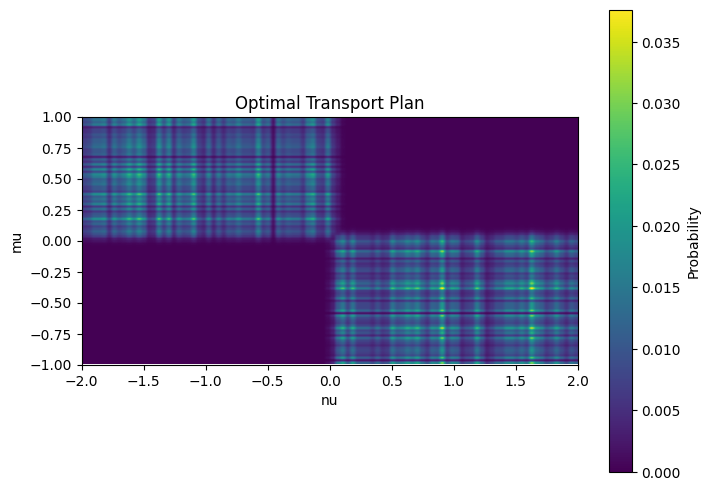

In [19]:
# Plot the optimal transport plan
plt.figure(figsize=(8, 6))
plt.imshow(transport_plan, cmap='viridis', origin='lower', extent=[-2, 2, -1, 1])
plt.colorbar(label='Probability')
plt.xlabel('nu')
plt.ylabel('mu')
plt.title('Optimal Transport Plan')
plt.show()

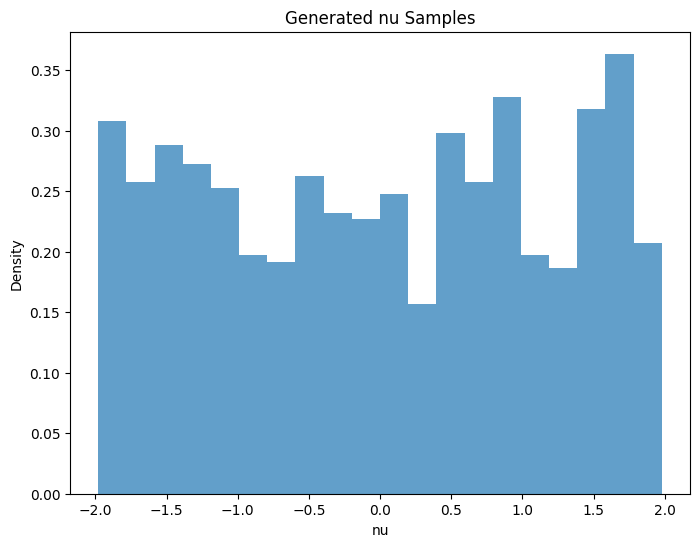

In [20]:
plt.figure(figsize=(8, 6))
plt.hist(new_y_samples, bins=20, density=True, alpha=0.7)
plt.xlabel('nu')
plt.ylabel('Density')
plt.title('Generated nu Samples')
plt.show()

In [22]:
# Verify that Y follows the uniform distribution on (-2, 2)
d, p_value = stats.kstest(new_y_samples, 'uniform', args=(-2, 4))
follow_law = p_value > 0.05
print("Y follows uniform distribution on (-2, 2):", follow_law)

# Compute the expected cost
expected_cost = np.mean(c(x_samples, new_y_samples, a))
print("Expected cost E[c(X, Y)]:", expected_cost)

# Verify the inequality
lhs = np.mean(c(x_samples, new_y_samples, a))
rhs = np.sqrt(np.mean((x_samples - new_y_samples)**2))
print("Inequality holds:", lhs <= rhs)

# Verify the martingale property
martingale_diff = np.mean(new_y_samples - x_samples)
print("Martingale difference:", martingale_diff)
print("Martingale difference is close to 0:", np.isclose(martingale_diff, 0, atol=0.03))

Y follows uniform distribution on (-2, 2): False
Expected cost E[c(X, Y)]: -0.38258275286611615
Inequality holds: True
Martingale difference: -0.0012041841579768118
Martingale difference is close to 0: True
